In [3]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
import cv2
from pathlib import Path
from math import ceil, floor

In [4]:
SOURCE_PATH = 'datasets/pills/data/train'
TARGET_PATH = 'datasets/pills/data/masked'
LABEL_PATH = 'datasets/pills/class_label.csv'

In [5]:
class_label = pd.read_csv(LABEL_PATH, header=0)

In [6]:
pills_dict = {}
for i, row in class_label.iterrows():
  pills = row['label'].split('#')
  pills = map(lambda x: x.strip(), pills)
  for pill in pills:
    pills_dict.setdefault(pill, []).append(row['class'])

In [7]:
len(pills_dict)

50

In [8]:
test_img = {}
for pill, classes in pills_dict.items():
  for c in classes:
    pill_path = Path(f'{SOURCE_PATH}/{c}')
    file = next(pill_path.glob('*.png'), None)
    if file is None: continue
    test_img[c] = file
    break
# test_img

In [9]:
class_label_dict = {}
for c, file in test_img.items():
  for _, row in class_label.iterrows():
    if c == row['class']:
      class_label_dict[c] = row['label'].split('#')
      break

In [10]:
# class_label_dict

In [11]:
def readImage(path:Path):
  img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  alpha_channel = img[:, :, 3]
  rgb_image = img[:, :, :3]
  background_mask = (alpha_channel == 0)
  rgb_image[background_mask, :] = 0
  return rgb_image

In [12]:
def getCounturs(img):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours

In [13]:
def getCentroid(contour):
  M = cv2.moments(contour)
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  return (cX, cY)

In [14]:
def draw_label_box(img, lx, ly, rx, ry, text, color=(0, 255, 0), thickness=1):
  cv2.rectangle(img, (lx, ly), (rx, ry), color, thickness)

  text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
  if ly - text_size[1] - 5 < 0:
    text_x, text_y = lx, ry + text_size[1]
    background_lx, background_ly = lx, ry
    background_rx, background_ry = rx, ry + text_size[1] + 5
  else:
    text_x, text_y = lx, ly - text_size[1]//2
    background_lx, background_ly = lx, ly - text_size[1] - 5
    background_rx, background_ry = rx, ly
    
  cv2.rectangle(img, (background_lx, background_ly), (background_rx, background_ry), color, -1)
  cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), thickness, cv2.LINE_AA)

In [15]:
def show(img):
  plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.show()

In [16]:
def show_images_grid(images, cols=5, spacing=0.01):
  n = len(images)
  rows = n // cols + (1 if n % cols != 0 else 0)
  fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
  for i, img in enumerate(images):
    ax = axes[i // cols, i % cols]
    ax.imshow(img)
    ax.axis('off')
  for i in range(n, rows*cols):
    fig.delaxes(axes.flatten()[i])
  plt.subplots_adjust(wspace=spacing, hspace=spacing)
  plt.show()

In [26]:
def is_circle(cnt):
  perimeter = cv2.arcLength(cnt, True)
  area = cv2.contourArea(cnt)

  circularity = 4 * np.pi * area / perimeter**2
  x, y, w, h = cv2.boundingRect(cnt)
  aspect_ratio = w / float(h)
  return circularity > 0.85 and 1.05 > aspect_ratio > 0.95

In [18]:
dif_pill_index = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0]

In [19]:
keys = list(test_img.keys())
for index, position in enumerate(dif_pill_index):
  key = keys[index]
  path = test_img[key]
  labels = class_label_dict[key]
  img = readImage(path)
  contours = getCounturs(img)
  x, y, w, h = cv2.boundingRect(contours[position])
  bgr_img = cv2.cvtColor(img[y:y+h, x:x+w], cv2.COLOR_RGB2BGRA)
  
  rect = cv2.minAreaRect(contours[position])
  angle = rect[2]
  if rect[1][0] < rect[1][1]:
    angle += 90
  
  (h, w) = bgr_img.shape[:2]
  center = (w // 2, h // 2)
  
  mask_img = (bgr_img[:, :, 0] == 0) & (bgr_img[:, :, 1] == 0) & (bgr_img[:, :, 2] == 0)
  bgr_img[mask_img, 3] = 0
  background = np.zeros(shape=(64, 64, 4), dtype=np.uint8)
  bg_h, bg_w = background.shape[:2]
  img_h, img_w = bgr_img.shape[:2]
  x_offset = (bg_w - img_w) // 2
  y_offset = (bg_h - img_h) // 2
  background[y_offset:y_offset+img_h, x_offset:x_offset+img_w] = bgr_img
  
  center_x = x_offset + img_w // 2
  center_y = y_offset + img_h // 2
  M = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)

  rotated = cv2.warpAffine(background, M, (bg_w, bg_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
  # show(rotated)
  # cv2.imwrite(f"./modules/Pills/single_img/{labels[1]}.png", background)

In [20]:
def is_equal(imageA, imageB, threshold=1e-4):
  imageA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
  imageB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)
  
  _, imgA = cv2.threshold(imageA, 128, 255, cv2.THRESH_BINARY)
  _, imgB = cv2.threshold(imageB, 128, 255, cv2.THRESH_BINARY)
  
  momentsA = cv2.moments(imgA)
  momentsB = cv2.moments(imgB)
  
  huA = cv2.HuMoments(momentsA).flatten()
  huB = cv2.HuMoments(momentsB).flatten()
  
  huA = -np.sign(huA) * np.log10(np.abs(huA))
  huB = -np.sign(huB) * np.log10(np.abs(huB))
  
  diff = np.sum(np.abs(huA - huB))
  return diff < threshold

In [21]:
def is_equal_orb(imageA, imageB, threshold=0.8):
  imageA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
  imageB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

  result = cv2.matchTemplate(imageA, imageB, cv2.TM_CCOEFF_NORMED)
  max_val = np.max(result)
  return max_val > threshold

In [22]:
base_pills = {}
base_pill_path = Path("modules/Pills/single_img")
for file in base_pill_path.glob('*.png'):
  base_pills[file.stem] = readImage(file)

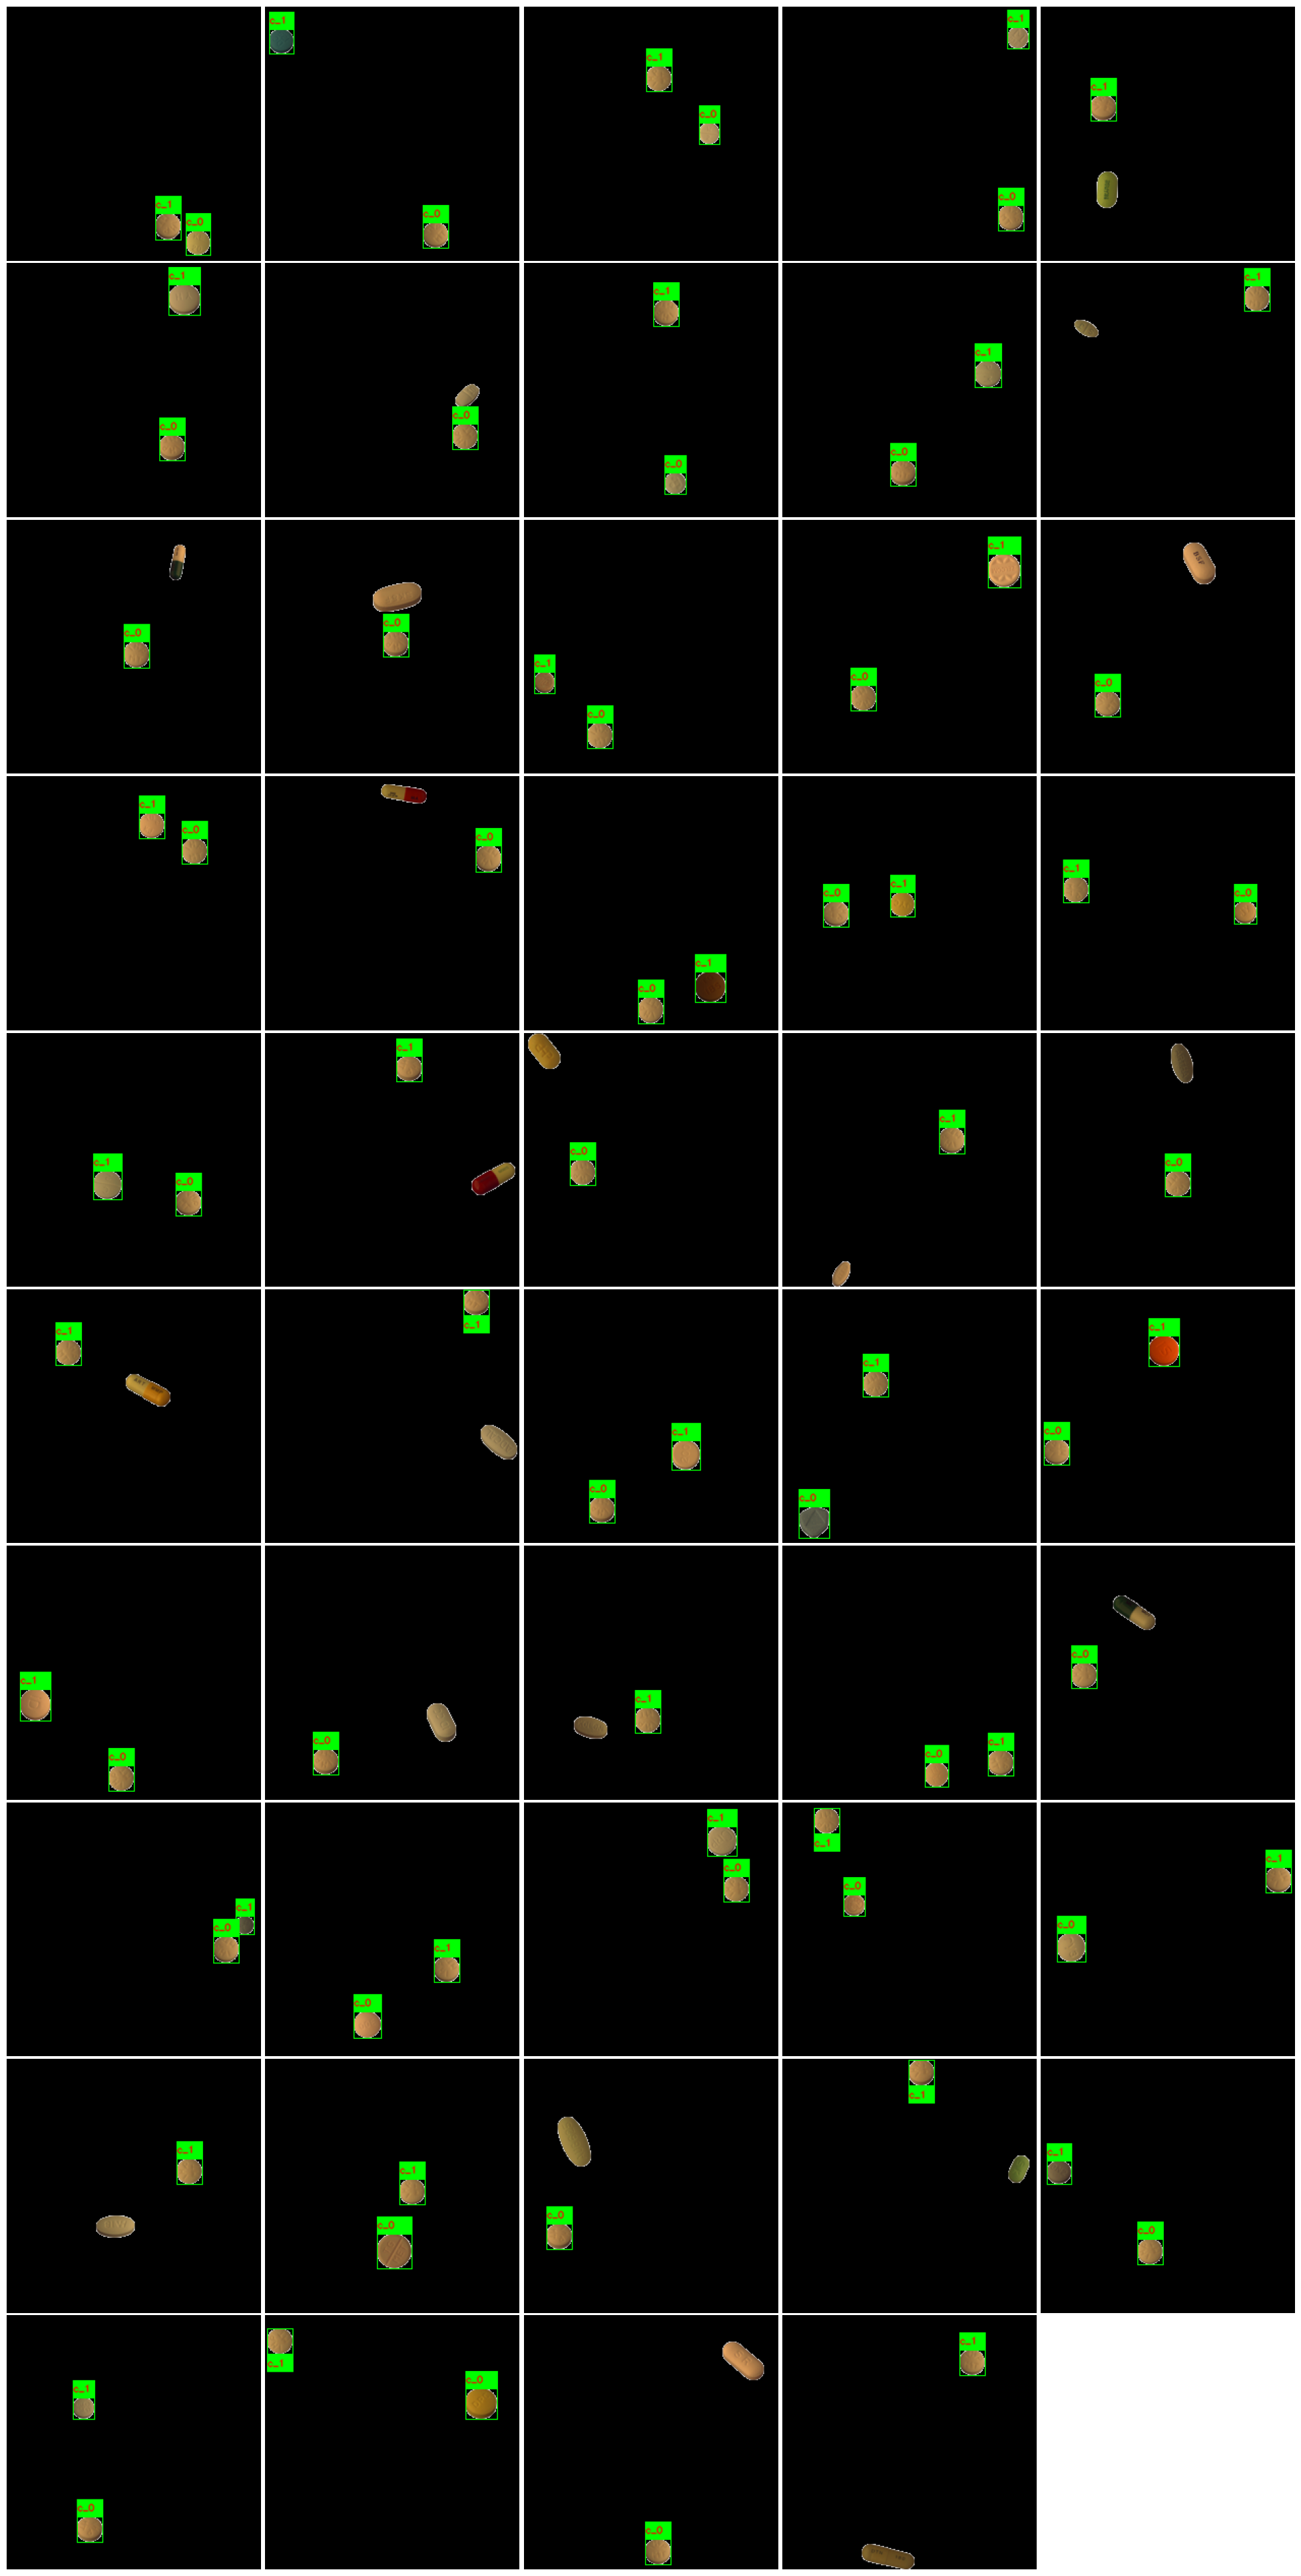

In [27]:
all_images = []
for c, path in test_img.items():
  img = readImage(path)
  contours = getCounturs(img)
  i = img.copy()
  for index, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    background = np.zeros(shape=(64, 64, 3), dtype=np.uint8)
    bg_shape = background.shape
    target = img[y:y+h, x:x+w]
    img_shape = target.shape
    background[floor(bg_shape[0]/2) - floor(img_shape[0]/2):ceil(bg_shape[0]/2) + ceil(img_shape[0]/2), floor(bg_shape[1]/2) - floor(img_shape[1]/2):ceil(bg_shape[1]/2) + ceil(img_shape[1]/2)] = target
    # for pill_name in base_pills.keys():
    #   if is_equal_orb(background, base_pills[pill_name], 0.6):
    #     draw_label_box(i, x, y, x + w, y + h, f'{pill_name}_{index}')
    #   break
    if is_circle(cnt):
      draw_label_box(i, x, y, x + w, y + h, f'c_{index}')
  all_images.append(i)
show_images_grid(all_images)